# Import Modules

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, GlobalMaxPooling2D, Dense
# To show images
from PIL import Image
print("status ok")

status ok



# Create Functions

#### Creates data frame

In [35]:
# Collect all data into one dataframe
def create_df(dataset, sample_size):
    image_paths, labels = [], []

    for dirpath, dirnames, filenames in os.walk(dataset):
        for i, filename in enumerate(filenames):
            if i >= sample_size:
                break
            
            image = os.path.join(dirpath, filename)
            image_paths.append(image)
            if dirpath[-3:] == 'all':
                labels.append('all')
            else:
                labels.append('hem')

    df = pd.DataFrame({'Image Path': image_paths, 
                       'Label': labels})
    
    return df

train_dir = "C-NMC_Leukemia/training_data"
df = create_df(train_dir, 500)

train_df, remaining_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=31, stratify=df['Label'])
valid_df, test_df = train_test_split(remaining_df, train_size=0.5, shuffle=True, random_state=31, stratify=remaining_df['Label'])

print("Number of training samples: %d" % len(train_df.index))
print("Number of test samples: %d" % len(test_df.index))  
print("Number of validation samples: %d" % len(valid_df.index))

Number of training samples: 2100
Number of test samples: 450
Number of validation samples: 450


#### Display Model Performance

In [36]:
def show_history_plot(history):

    training_accuracy = history['accuracy']
    epochs = range(1, len(training_accuracy) + 1)

    # Creating subplots for accuracy and loss
    plt.figure(figsize=(15, 5))

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.plot(epochs, history['accuracy'], 'b', label='Training accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], 'c', label='Validation accuracy', marker='o')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.plot(epochs, history['loss'], 'b', label='Training loss', marker='o')
    plt.plot(epochs, history['val_loss'], 'c', label='Validation loss', marker='o')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Improve layout and displaying the plot
    plt.tight_layout()
    plt.show()

#### Confusion Matrix

In [37]:
def show_conf_matrix(model):
    test_gen.reset()  # Reset the generator to be sure it's at the start of the dataset
    y_pred = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size+1, verbose=0)

    label_dict = test_gen.class_indices
    classes = list(label_dict.keys())

    # Convert predictions to labels
    pred_labels = np.argmax(y_pred, axis=1)  
    y_true = test_gen.classes  
    
    # Generate the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_true, pred_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])

    # Plot the confusion matrix 
    cmap = plt.cm.Blues
    cm_display.plot(cmap=cmap, colorbar=False)  
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.figure(figsize=(7, 7)) 
    plt.show()

#### Evaluation Matrix

In [38]:
def evaluation_matrix(model):
    test_steps = len(test_df) // batch_size
    train_score = model.evaluate(train_gen, steps= test_steps, verbose= 0)
    valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 0)
    test_score = model.evaluate(test_gen, steps= test_steps, verbose= 0)

    header = "{:<12} {:<10} {:<10}".format("", "Loss", "Accuracy") 
    separator = '-' * len(header)
    train_row = "{:<12} {:<10.5f} {:<10.5f}".format("Train", train_score[0], train_score[1])  # Formats the float to five decimal places
    valid_row = "{:<12} {:<10.5f} {:<10.5f}".format("Validation", valid_score[0], valid_score[1])
    test_row = "{:<12} {:<10.5f} {:<10.5f}".format("Test", test_score[0], test_score[1])

    table = '\n'.join([header, separator, train_row, valid_row, test_row])
    print(table)

#### Show Images

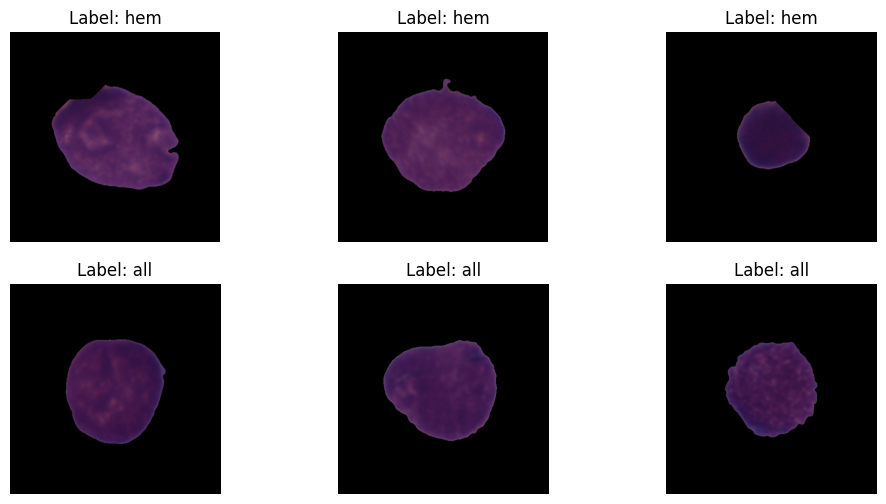

In [39]:
hem_img = train_df[train_df['Label'] == 'hem'].sample(3)
all_img = train_df[train_df['Label'] == 'all'].sample(3)
sampled_df = pd.concat([hem_img, all_img])

# Create a figure with subplots to show the images in
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i, row in enumerate(sampled_df.iterrows()):
    img = mpimg.imread(row[1]['Image Path'])
    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.axis('off')    
    if row[1]['Label'] == 'hem':
        ax.set_title(f"Label: hem")
    else:
        ax.set_title(f"Label: all")

plt.show()

#### Initializing Image Data Generators 

In [40]:
batch_size = 40

train_data_generator = ImageDataGenerator(horizontal_flip=True)
valid_data_generator = ImageDataGenerator()

train_gen = train_data_generator.flow_from_dataframe( train_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = valid_data_generator.flow_from_dataframe( valid_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = valid_data_generator.flow_from_dataframe( test_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

train_steps = test_gen.n // test_gen.batch_size + 1
validation_steps = valid_gen.n // valid_gen.batch_size 

Found 2100 validated image filenames belonging to 2 classes.
Found 450 validated image filenames belonging to 2 classes.
Found 450 validated image filenames belonging to 2 classes.


## Hybrid Model

In [41]:
#Load pretrained models from the h5 folder
from tensorflow.keras.models import load_model

xception_model=load_model("./LeukemiaResearch/h5files/LeukXception.h5")
inception_model=load_model("./LeukemiaResearch/h5files/LeukInception.h5")

In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, BatchNormalization
from tensorflow.keras.regularizers import l2


model1 = xception_model
model2 = inception_model

input_layer = Input(shape=(224,224,3))

output1 = model1(input_layer)
output2 = model2(input_layer)

x1 = Dense(2048, activation = "relu", kernel_regularizer=l2(0.01))(output1)
x1 = BatchNormalization()(x1)
x2 = Dense(2048, activation = "relu", kernel_regularizer=l2(0.01))(output2)
x2 = BatchNormalization()(x2)

merged = concatenate([x1,x2])
merged = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(merged)   
merged = BatchNormalization()(merged)
d1 = Dropout(0.4)(merged)
h2 = Dense(512, activation = "relu", kernel_regularizer=l2(0.01))(d1)
h2 = BatchNormalization()(h2)
d2 = Dropout(0.4)(h2)

output = Dense(2, activation='sigmoid')(d2)

ensemble_model = Model(inputs=input_layer, outputs=output)


#### Train Model

In [47]:
from tensorflow.keras.metrics import Recall, Precision
ensemble_model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='binary_crossentropy',  # Use 'binary_crossentropy' for binary classification
    metrics=['accuracy', Recall(name='recall'), Precision(name='precision')]
)

ensemble_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Xception (Functional)       (None, 2)                    1769066   ['input_5[0][0]']             
                                                          6                                       
                                                                                                  
 InceptionV3 (Functional)    (None, 2)                    8976802   ['input_5[0][0]']             
                                                                                                  
 dense_20 (Dense)            (None, 2048)                 6144      ['Xception[1][0]']      

Total params: 31423438 (119.87 MB)
Trainable params: 4749318 (18.12 MB)
Non-trainable params: 26674120 (101.75 MB)
__________________________________________________________________________________________________


In [48]:
epochs = 15

history_ensemble = ensemble_model.fit(
    train_gen, 
    steps_per_epoch=train_steps,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/15
12/12 [==============================] - 43s 3s/step - loss: 21.8300 - accuracy: 0.5521 - recall: 0.5521 - precision: 0.5441 - val_loss: 19.0526 - val_accuracy: 0.5432 - val_recall: 0.8705 - val_precision: 0.5956
Epoch 2/15
12/12 [==============================] - 37s 3s/step - loss: 17.8295 - accuracy: 0.6479 - recall: 0.6542 - precision: 0.6293 - val_loss: 16.2882 - val_accuracy: 0.6750 - val_recall: 0.6909 - val_precision: 0.6609
Epoch 3/15
12/12 [==============================] - 37s 3s/step - loss: 15.5779 - accuracy: 0.6083 - recall: 0.5854 - precision: 0.5979 - val_loss: 14.5342 - val_accuracy: 0.5114 - val_recall: 0.8409 - val_precision: 0.5710
Epoch 4/15
12/12 [==============================] - 37s 3s/step - loss: 14.0336 - accuracy: 0.6687 - recall: 0.6271 - precision: 0.6377 - val_loss: 13.2374 - val_accuracy: 0.5023 - val_recall: 0.5023 - val_precision: 0.5023
Epoch 5/15
12/12 [==============================] - 37s 3s/step - loss: 12.8046 - accuracy: 0.7146 - rec

: 

#### Evaluate Model

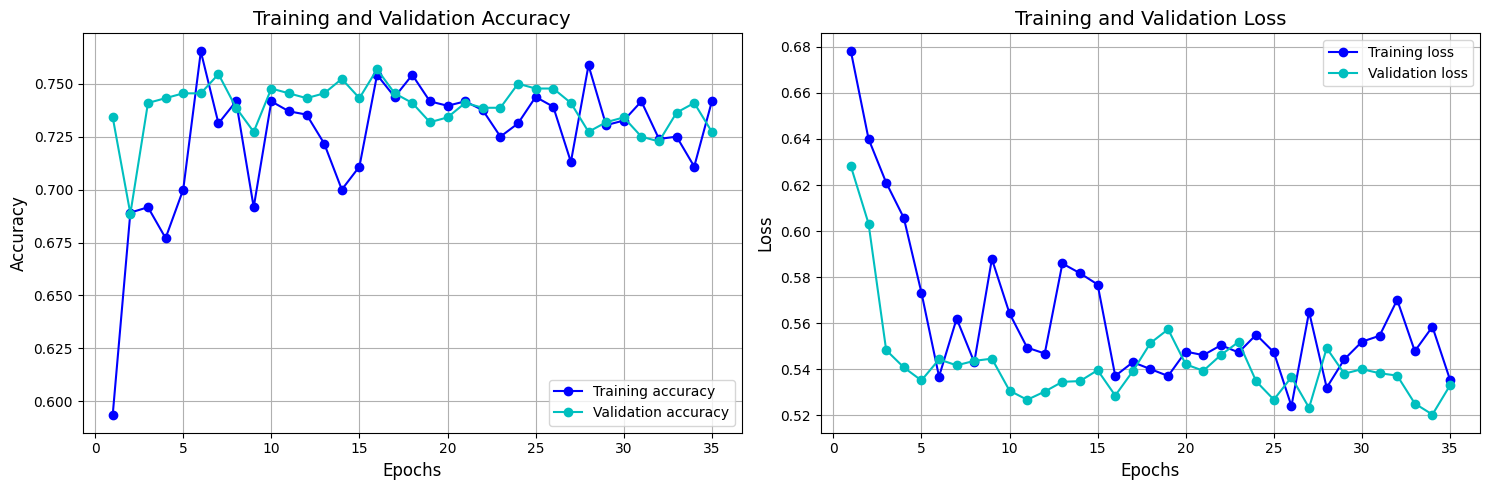

In [ ]:
show_history_plot(history_ensemble.history)


In [ ]:
evaluation_matrix(ensemble_model)

             Loss       Accuracy  
----------------------------------
Train        0.50467    0.75909   
Validation   0.53265    0.72727   
Test         0.53713    0.75909   


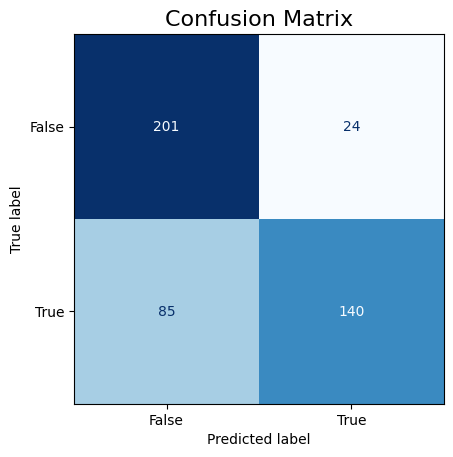

<Figure size 700x700 with 0 Axes>

In [ ]:
show_conf_matrix(ensemble_model)

In [ ]:
ensemble_model.save('LeukHybrid15.h5')

/home/the_architect/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


ValueError: Unable to create dataset (name already exists)